In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
import os
import sys

'''
Script to compare litos and stability setup JV scan pixel by pixel
replace file path below
'''

# litos_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\Litos_analyzed\0\Data\photo - 0p_0.0Sun_Scan0.txt"
# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\0p\Nov-08-2023 15_57_40lightID1scan.csv"



[0]
[0]
[0]
[0]
0.0013499999999999623 0.024100999999999928
0.008996000000000004 0.05205300000000013
0.012725499999999945 0.030524500000000065


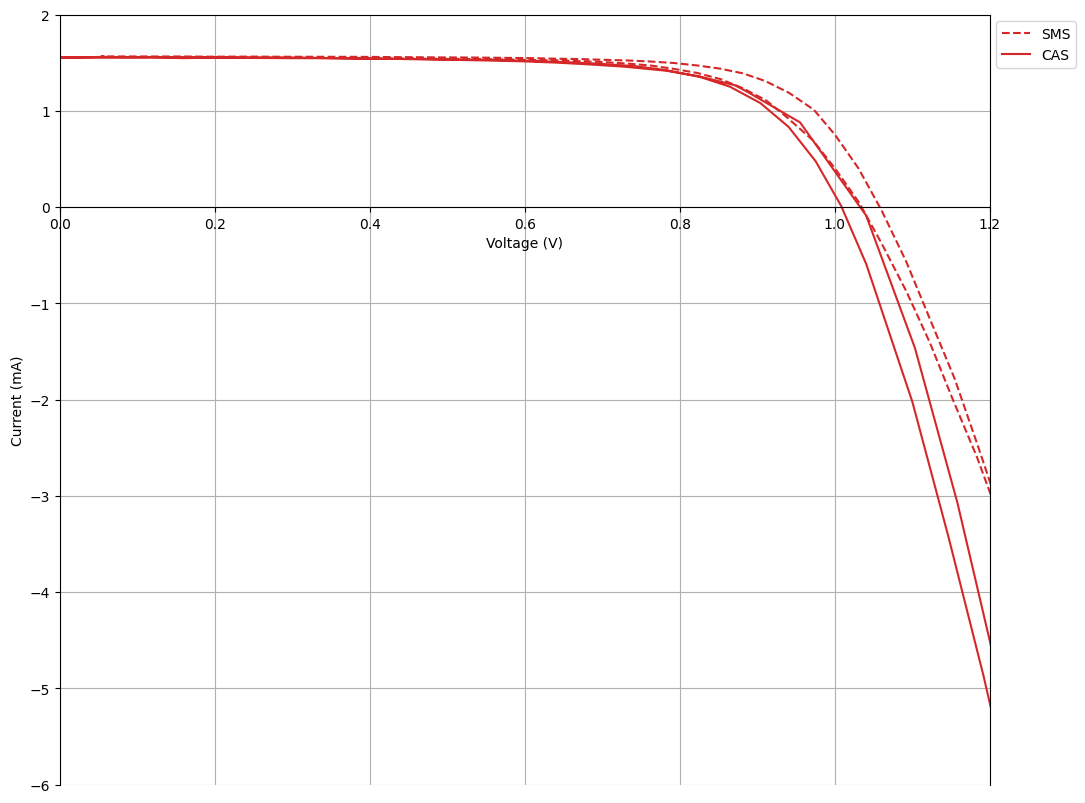

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
from matplotlib.font_manager import FontProperties
import os
import sys
import re

def plot_difference(litos_directory, ss_file_path):
    # litos_directory = ""
    # litos_directory = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- Litos New PCB 4 Device comparison\devices\device_2"

    all_files = []

    if litos_directory != "":
        for root, dirs, files in os.walk(litos_directory):
            for file in files:
                if file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    all_files.append(file_path)

    litos_voltage = []
    litos_current = []

    # Process each file
    for file_path in all_files:
        if "_1_0" in file_path:
            try:
                data = np.genfromtxt(
                    file_path,
                    delimiter=',',
                    comments='#',
                    skip_header=0,
                    encoding='cp1252'  # Specify the correct encoding
                )
                voltage = data[:, 0]
                current = data[:,1]
                # data_with_pce= np.column_stack((data, pce))

                litos_voltage.append(voltage)
                litos_current.append(current)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    np.set_printoptions(threshold=np.inf)
    data = []
    # ss_file_path = ""
    # ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID2__mppt.csv"
    if ss_file_path != "":
        arr = np.loadtxt(ss_file_path, delimiter=",", dtype=str)
        header_row = np.where(arr == "Time")[0][0]

        meta_data = {}
        for data in arr[:header_row, :2]:
            meta_data[data[0]] = data[1]

        headers = arr[header_row, :]
        arr = arr[header_row + 1 :, :]

        data = arr[:, 2:-1]

        pixel_V = data[:, ::2][:, ::-1].astype(float)
        pixel_mA = data[:, 1::2][:, ::-1].astype(float)
        # if ("Cell Area (mm^2)" in meta_data):
        #     pixel_mA /= float(meta_data["Cell Area (mm^2)"])
        # else:
        #     pixel_mA /= 0.128

    plt.figure(figsize=(12,10))
    plt.xlim(0,1.2)
    plt.ylim(bottom = -6, top = 2)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (mA)')
    plt.grid()
    ax = plt.gca()
    ax.spines['bottom'].set_position(('data', 0))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    avg_vmpp_diff_forward = []
    avg_voc_diff_forward = []
    avg_vmpp_diff_reverse = []
    avg_voc_diff_reverse = []
    for i in range(3,4):

        lineName = "SMS"
        if ss_file_path:
            plt.plot(pixel_V[:,i],
                     pixel_mA[:,i],
                     linestyle='--',
                     color=colors[i % len(colors)],
                     label = lineName)
        if True:
            # plt.hlines(pce[i], x_start, x_end, label="litos_pce" + str(i + 1))
            plt.plot(litos_voltage[i],
                     litos_current[i],
                     color=colors[i % len(colors)],
                     label = "CAS")

        ss_half = len(pixel_V[:, i]) // 2
        litos_half = len(litos_voltage[i]) // 2

        # Forward Scan
        pceList = pixel_V[:ss_half, i] * pixel_mA[:ss_half, i]
        pceListLitos = litos_voltage[i][:litos_half] * litos_current[i][:litos_half]

        max_V_idx = np.argmax(pceList, axis=0)  # index relative to first half
        max_V_idx_litos = np.nanargmax(pceListLitos, axis=0)  # relative to first half
        avg_vmpp_diff_forward.append(
            abs(pixel_V[max_V_idx, i] - litos_voltage[i][max_V_idx_litos])
        )

        # Voc calculation for forward scan using the first half
        min_current_idx = min(
            range(len(pixel_mA[:ss_half, i])),
            key=lambda x: abs(pixel_mA[:ss_half, i][x])
        )
        min_current_idx_litos = min(
            range(len(litos_current[i][:litos_half])),
            key=lambda x: abs(litos_current[i][:litos_half][x])
        )
        avg_voc_diff_forward.append(
            abs(pixel_V[min_current_idx, i] - litos_voltage[i][min_current_idx_litos])
        )

        # Reverse Scan
        pceList = pixel_V[ss_half:, i] * pixel_mA[ss_half:, i]
        pceListLitos = litos_voltage[i][litos_half:] * litos_current[i][litos_half:]

        max_V_idx_relative = np.argmax(pceList, axis=0)
        max_V_idx = max_V_idx_relative + ss_half  # adjust index for full array
        max_V_idx_litos_relative = np.nanargmax(pceListLitos, axis=0)
        max_V_idx_litos = max_V_idx_litos_relative + litos_half  # adjust index

        avg_vmpp_diff_reverse.append(
            abs(pixel_V[max_V_idx, i] - litos_voltage[i][max_V_idx_litos])
        )

        # Voc calculation for reverse scan using the second half
        min_current_idx_relative = min(
            range(len(pixel_mA[ss_half:, i])),
            key=lambda x: abs(pixel_mA[ss_half:, i][x])
        )
        min_current_idx = min_current_idx_relative + ss_half  # adjust index
        min_current_idx_litos_relative = min(
            range(len(litos_current[i][litos_half:])),
            key=lambda x: abs(litos_current[i][litos_half:][x])
        )
        min_current_idx_litos = min_current_idx_litos_relative + litos_half  # adjust index

        avg_voc_diff_reverse.append(
            abs(pixel_V[min_current_idx, i] - litos_voltage[i][min_current_idx_litos])
        )



    plt.legend(bbox_to_anchor=(1.1, 1))
    return avg_vmpp_diff_forward, avg_voc_diff_forward, avg_vmpp_diff_reverse, avg_voc_diff_reverse
files = [
        # [r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-20-2025 Litos and Stability High PCE test\20-3-2025 litos\device 1",
        #     r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-20-2025 Litos and Stability High PCE test\Mar-20-2025 13_17_46__Ahmed 4 Device Litos Comparison\Mar-20-2025_12-12-31__Ahmed 4 Device Litos Comparison__ID1__light__scan.csv"],
        #  [r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-20-2025 Litos and Stability High PCE test\20-3-2025 litos\device 2",
        #     r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-20-2025 Litos and Stability High PCE test\Mar-20-2025 13_17_46__Ahmed 4 Device Litos Comparison\Mar-20-2025_12-12-31__Ahmed 4 Device Litos Comparison__ID2__light__scan.csv"],
         [r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-20-2025 Litos and Stability High PCE test\20-3-2025 litos\device 3",
            r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-20-2025 Litos and Stability High PCE test\Mar-20-2025 13_17_46__Ahmed 4 Device Litos Comparison\Mar-20-2025_12-12-31__Ahmed 4 Device Litos Comparison__ID3__light__scan.csv"],
        #  [r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-20-2025 Litos and Stability High PCE test\20-3-2025 litos\device 4",
        #     r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-20-2025 Litos and Stability High PCE test\Mar-20-2025 13_17_46__Ahmed 4 Device Litos Comparison\Mar-20-2025_12-12-31__Ahmed 4 Device Litos Comparison__ID4__light__scan.csv"],
         ]

vmpp_diffs_forward = []
vmpp_diffs_reverse = []
voc_diffs_forward = []
voc_diffs_reverse = []
for litos, ss_file in files:
    vmpp_diff_forward, voc_diff_forward, vmpp_diff_reverse, voc_diff_reverse = plot_difference(litos, ss_file)
    vmpp_diffs_forward += [float(x) for x in vmpp_diff_forward]
    voc_diffs_forward += [float(x) for x in voc_diff_forward]
    vmpp_diffs_reverse += [float(x) for x in vmpp_diff_reverse]
    voc_diffs_reverse += [float(x) for x in voc_diff_reverse]
print(np.argsort(vmpp_diffs_forward))
print(np.argsort(vmpp_diffs_reverse))
print(np.argsort(voc_diffs_forward))
print(np.argsort(voc_diffs_reverse))
# print(vmpp_diffs[10], voc_diffs[10])
print(np.mean(vmpp_diffs_forward), np.mean(vmpp_diffs_reverse))
print(np.mean(voc_diffs_forward), np.mean(voc_diffs_reverse))
print(np.mean(vmpp_diffs_forward + vmpp_diffs_reverse), np.mean(voc_diffs_forward + voc_diffs_reverse))


c:\Users\achen\miniforge3\envs\stabilitySetup\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.0, xmax=0.0943, xval=0.12662563500000004). Clipping it into the allowed range.
  warnings.warn(


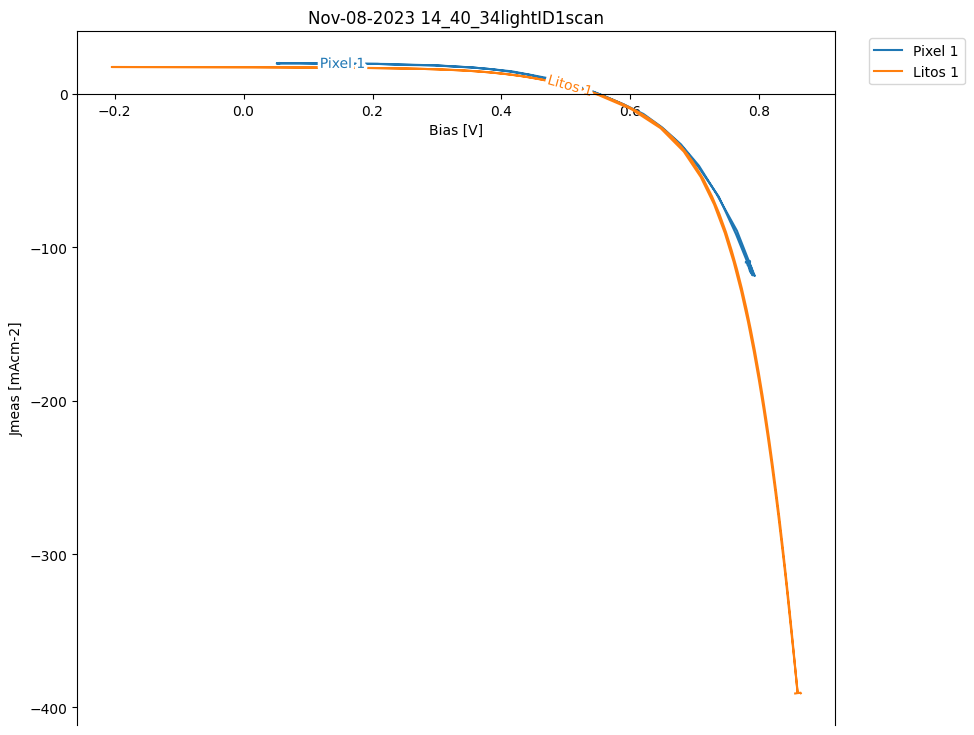

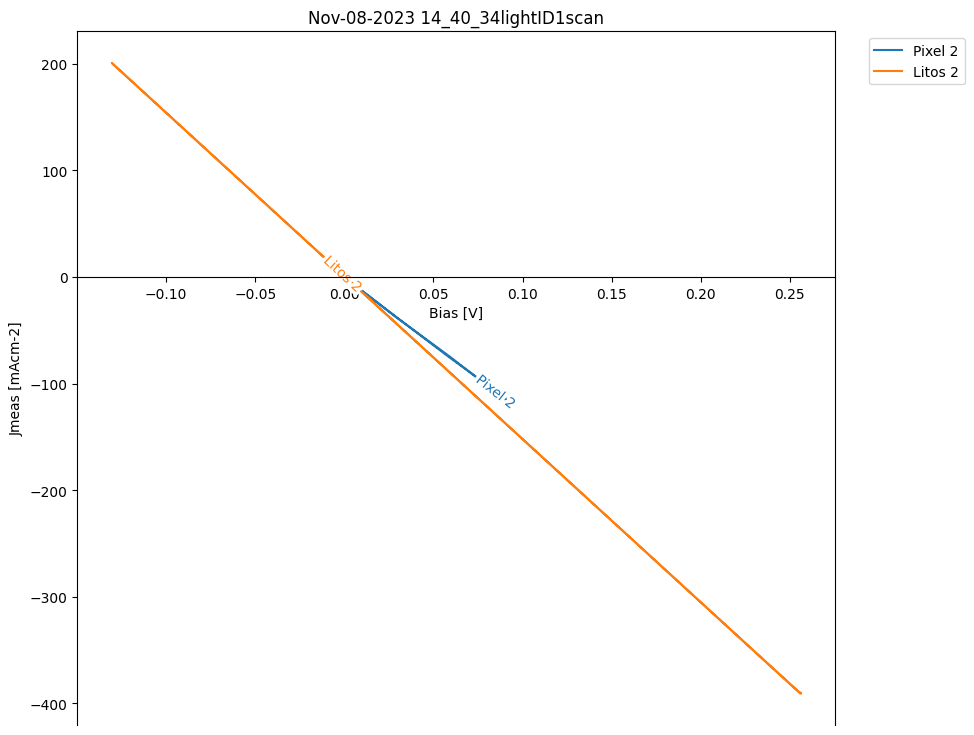

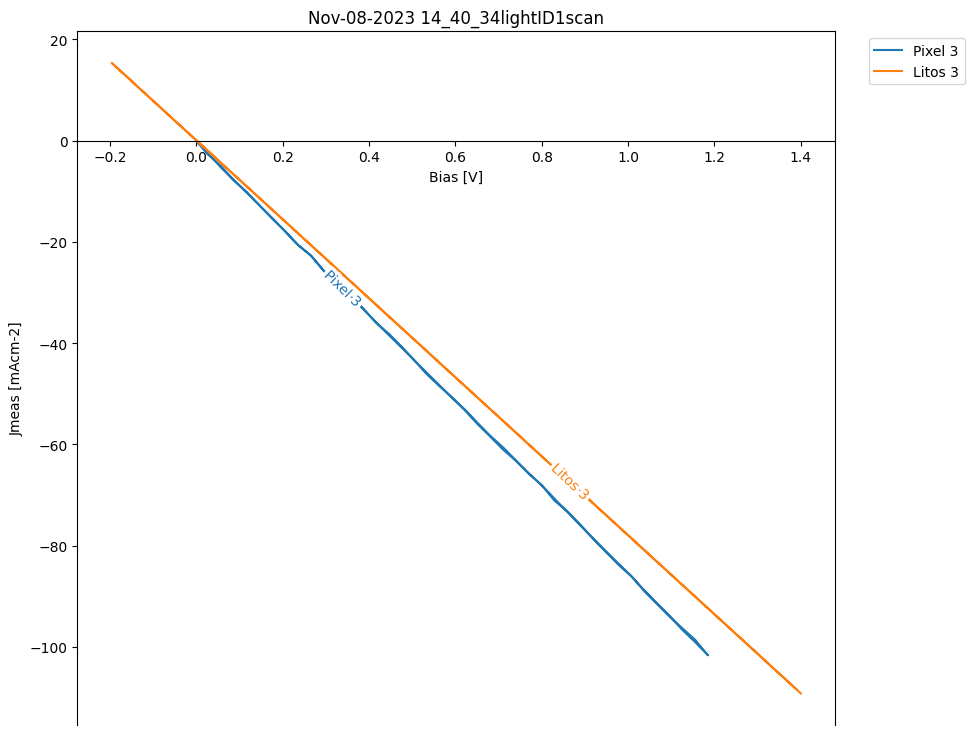

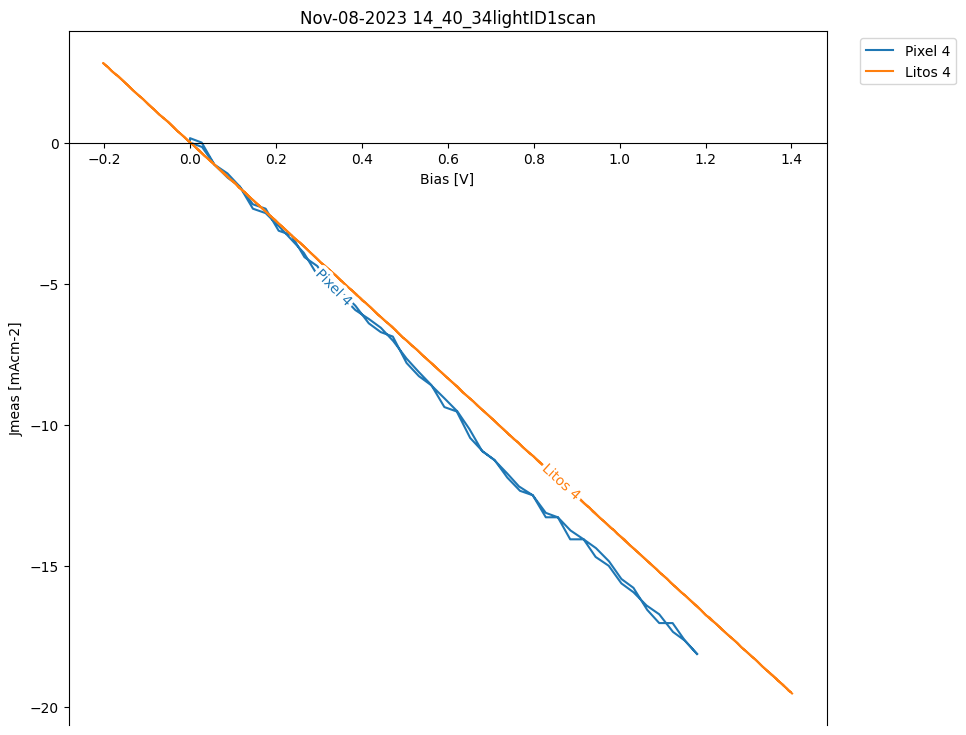

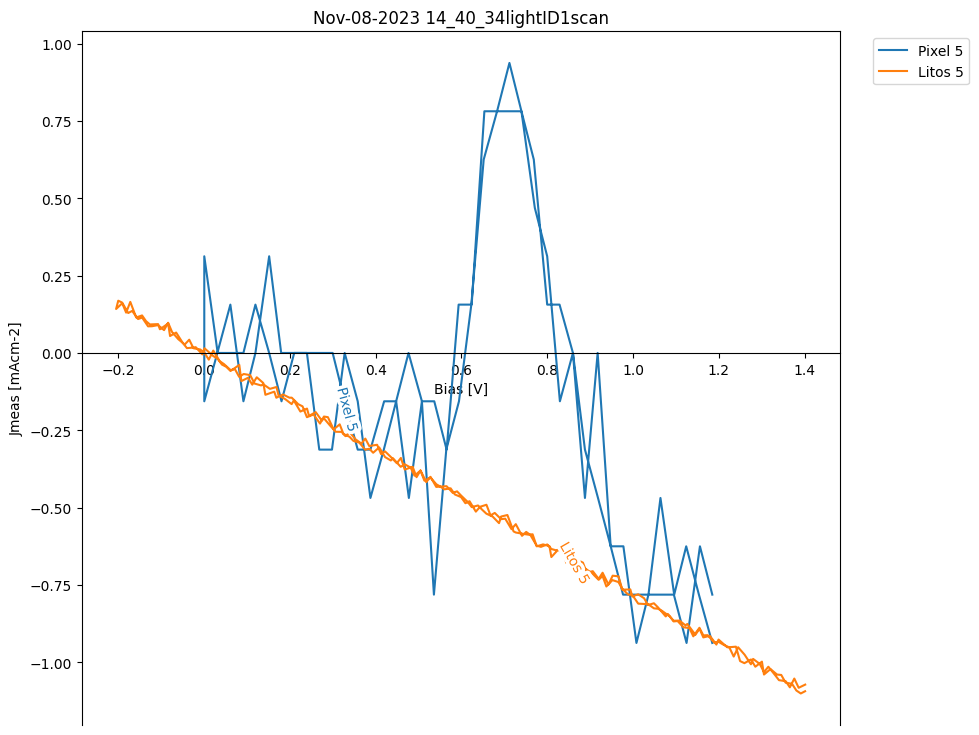

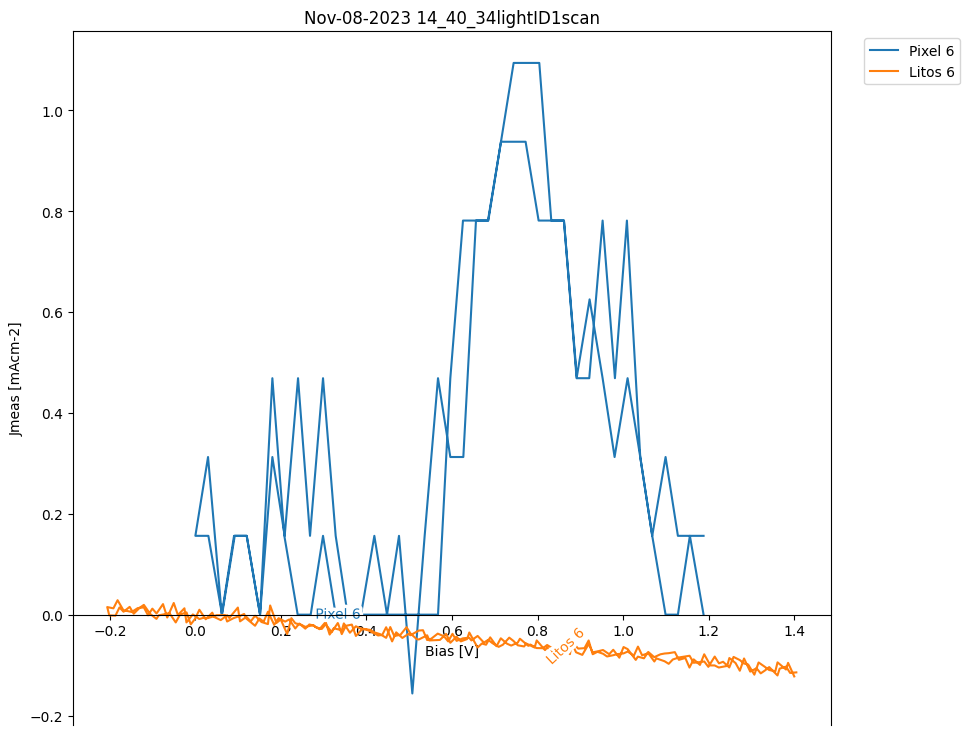

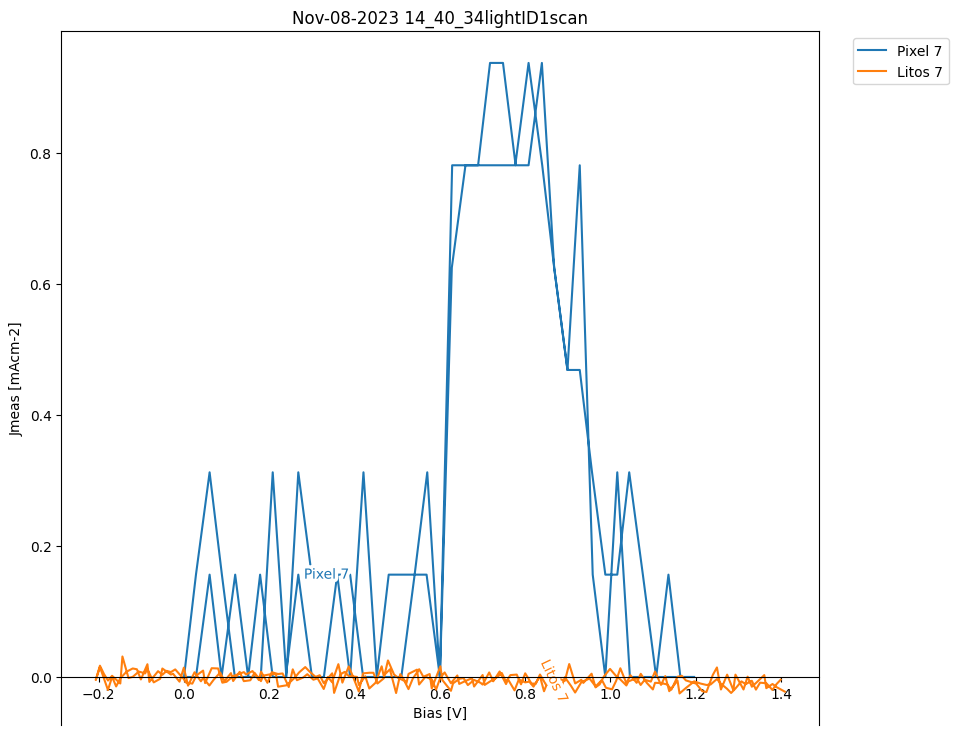

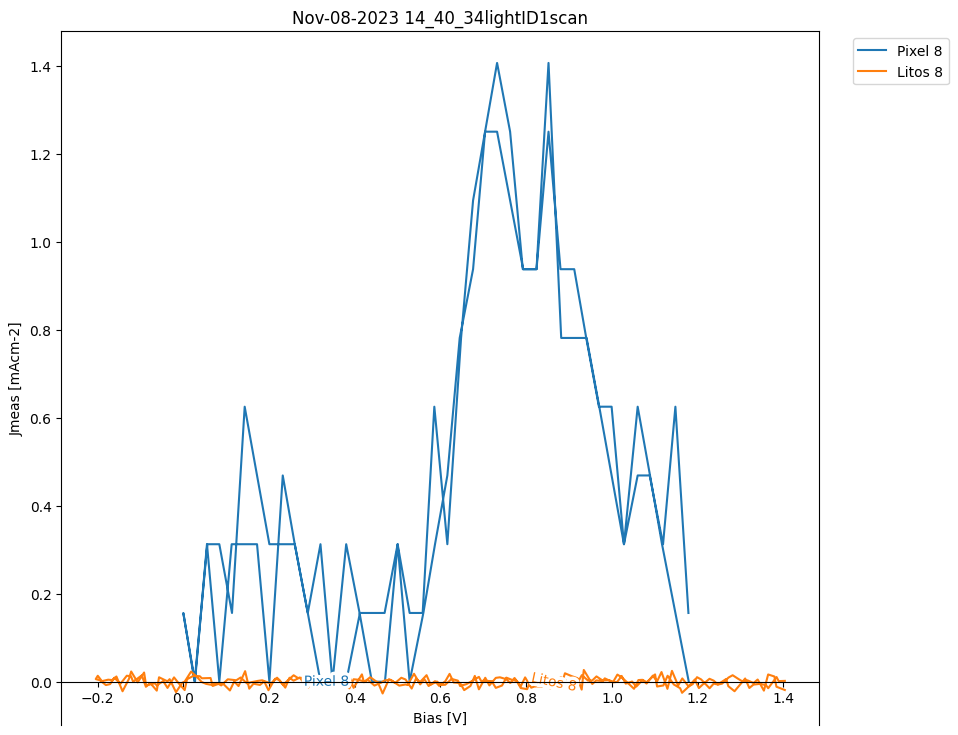

In [ ]:

litos_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\Litos_analyzed\100\Data\photo - 100p_1.0Sun_Scan0.txt"
ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\100p\Nov-08-2023 14_40_34lightID1scan.csv"

litos = np.loadtxt(litos_file_path,
                     delimiter="\t",
                     dtype=str)
litos = litos.T
litos = litos[:,1:].astype(float)

arr = np.loadtxt(ss_file_path,
                     delimiter=",",
                     dtype=str)
NUM_DEVICES = int((arr.shape[1]-2)/16)
device_to_pixels = {}
for i in range(NUM_DEVICES):
    device_to_pixels[i] = [j + 8*i for j in range(8)]

headers = arr[6,:]
header_dict = {value: index for index, value in enumerate(headers)}
arr = arr[7:, :]
voltage = arr[:, 2]
length = (len(headers) - 1)


jvList = []
for i in range(2, length): #remove timing and voltage output from array
    jvList.append(arr[:,i])

for i in range(0,len(jvList),2):
    # print(i)
    jvList[i] = [float(j) for j in jvList[i]]
    # jvList[i] = [float(v) - 5*float(j)*0.001 for v, j in zip(jvList[i], jvList[i+1])]
    jvList[i+1] = [float(x)/0.128 for x in jvList[i+1]]

# print(jvList)

plot_size = (10,8)
maxX = 1.3
minX = 0
maxY = 26
minY = -2

for i in range(0,len(litos),4):

    plot_title_orig = ss_file_path[:-4].split("\\")[-1]

    plt.figure(figsize=plot_size)
    # plt.xlim(minX,maxX)
    # plt.ylim(minY, maxY)
    plt.title(plot_title_orig)
    plt.xlabel('Bias [V]')
    plt.ylabel('Jmeas [mAcm-2]')
    # plt.ylabel('Jmeas [mA/cm]')
    plt.subplots_adjust(left=0.086, bottom=0.06, right=0.844, top=0.927, wspace=0.2, hspace=0.2)
    # print(dead_pixel, show_dead_pixels)
    # print(i)
    lineName = "Pixel " + str(int(i/4) + 1)
    # print(jvList[i],jvList[i+1])
    plt.plot(jvList[i//2],jvList[i//2+1], label = lineName)

    lineName = "Litos " + str(int(i/4) + 1)
    # print(litos[i],litos[i+1])

    plt.plot(np.concatenate((litos[len(litos)-(i+4)],litos[len(litos)-(i+2)])),np.concatenate((litos[len(litos)-(i+3)],litos[len(litos)-(i+1)])), label = lineName)

    ax = plt.gca()
    ax.spines['bottom'].set_position('zero')
    labelLines(plt.gca().get_lines(), zorder=2.5)

    plt.legend(bbox_to_anchor=(1.18, 1))
    plt.plot()

c:\Users\achen\miniforge3\envs\stabilitySetup\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=0.0, xmax=0.0943, xval=1.3455882352941178). Clipping it into the allowed range.
  warnings.warn(


[]

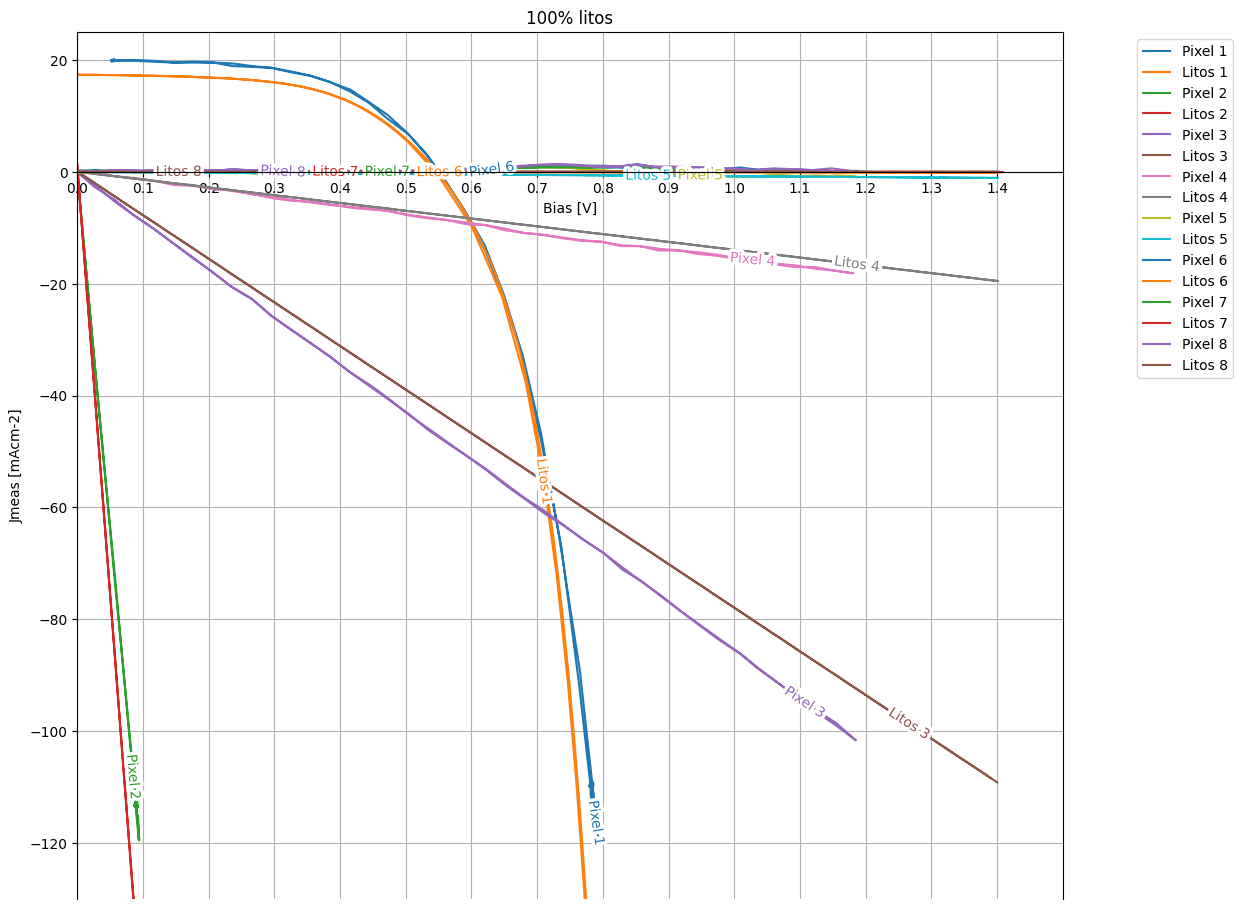

In [9]:

# litos_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\Litos_analyzed\100\Data\photo - 100p_1.0Sun_Scan0.txt"
# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\100p\Nov-08-2023 14_40_34lightID1scan.csv"

litos = np.loadtxt(litos_file_path,
                     delimiter="\t",
                     dtype=str)
litos = litos.T
litos = litos[:,1:].astype(float)

arr = np.loadtxt(ss_file_path,
                     delimiter=",",
                     dtype=str)
NUM_DEVICES = int((arr.shape[1]-2)/16)
device_to_pixels = {}
for i in range(NUM_DEVICES):
    device_to_pixels[i] = [j + 8*i for j in range(8)]

headers = arr[6,:]
header_dict = {value: index for index, value in enumerate(headers)}
arr = arr[7:, :]
voltage = arr[:, 2]
length = (len(headers) - 1)


jvList = []
for i in range(2, length): #remove timing and voltage output from array
    jvList.append(arr[:,i])

for i in range(0,len(jvList),2):
    # print(i)
    jvList[i] = [float(j) for j in jvList[i]]
    # jvList[i] = [float(v) + 5*float(j)*0.001 for v, j in zip(jvList[i], jvList[i+1])]
    jvList[i+1] = [float(x)/0.128 for x in jvList[i+1]]




# print(jvList)

plot_size = (13,10)

maxX = 1.5
minX = 0
maxY = 25
minY = -130
plot_title_orig = "100% litos"

plt.figure(figsize=plot_size)
plt.xlim(minX,maxX)
plt.ylim(minY, maxY)
plt.title(plot_title_orig)
plt.xlabel('Bias [V]')
plt.ylabel('Jmeas [mAcm-2]')
# plt.ylabel('Jmeas [mA/cm]')
plt.subplots_adjust(left=0.086, bottom=0.06, right=0.844, top=0.927, wspace=0.2, hspace=0.2)

for i in range(0,len(litos),4):
    # print(dead_pixel, show_dead_pixels)
    # print(i)
    litos_volt = np.concatenate((litos[len(litos)-(i+4)],litos[len(litos)-(i+2)]))
    litos_curr = np.concatenate((litos[len(litos)-(i+3)],litos[len(litos)-(i+1)]))
    # break
    litos_pce = max(litos_volt*litos_curr)
    setup_pce = max(np.array(jvList[i//2])*np.array(jvList[i//2+1]))

    # diff = np.diff()

    lineName = "Pixel " + str(int(i/4) + 1)
    # print(jvList[i],jvList[i+1])
    plt.plot(jvList[i//2],jvList[i//2+1], label = lineName)

    lineName = "Litos " + str(int(i/4) + 1)
    # print(litos[i],litos[i+1])
    plt.plot(np.concatenate((litos[len(litos)-(i+4)],litos[len(litos)-(i+2)])),np.concatenate((litos[len(litos)-(i+3)],litos[len(litos)-(i+1)])), label = lineName)

    # plt.plot(np.concatenate((litos[len(litos)-(i+4)],litos[len(litos)-(i+2)])),np.concatenate((litos[len(litos)-(i+3)],litos[len(litos)-(i+1)])), label = lineName)
plt.xticks(np.arange(minX, maxX, 0.1))
ax = plt.gca()
ax.spines['bottom'].set_position('zero')
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.grid()
plt.legend(bbox_to_anchor=(1.18, 1))
plt.plot()